In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.molecule_dataset as molecule_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.gnn as gnn
import model.util as model_util
import analysis.graph_metrics as graph_metrics
import analysis.mmd as mmd
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
# Create the data loader for training
dataset = molecule_dataset.ZINCDataset(connectivity_only=True)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=0  # TODO: allow multi-processing
)

### Import the model

In [4]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliSkipDiffuser(100, 10, (1,))  # Make input shape just 1
t_limit = 1000

base_path = "/gstore/data/resbioai/tsenga5/discrete_graph_diffusion/models/trained_models"
model_path = os.path.join(base_path, "zinc-conn_edge-flip", "4", "last_ckpt.pth")

model = model_util.load_model(gnn.GraphLinkGAT, model_path).to(DEVICE)

### Show generated graphs

In [5]:
def sample_prior():
    """
    Samples from the prior distribution. Returns a batch as a Data object.
    """
    data = next(iter(data_loader))
    edges = graph_conversions.pyg_data_to_edge_vector(data)
    sampled_edges = diffuser.sample_prior(
        edges.shape[0], # Samples will be E x 1
        torch.tile(torch.tensor([t_limit], device=DEVICE), edges.shape)
    )[:, 0]  # Shape: E
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, sampled_edges)
    return data

In [6]:
ATOM_COLORS = {
    "C": "gray",
    "O": "lightcoral",
    "N": "royalblue"
}
ATOM_SYMBOLS = ["C", "N", "O", "F", "S", "Cl", "Br", "I", "P"]

def plot_molecule(mol_graph):
    colors, symbols = [], {}
    for node in mol_graph.nodes():
        symbol_index = np.where(mol_graph.nodes[node]["feats"])[0][0]
        symbol = ATOM_SYMBOLS[symbol_index]
        try:
            colors.append(ATOM_COLORS[symbol])
        except KeyError:
            colors.append("violet")
        symbols[node] = symbol
    nx.draw(
        mol_graph,
        labels=symbols,
        with_labels=True,
        node_color=colors,
        node_size=500
    )
    plt.show()

In [7]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")
prior = sample_prior()
samples = generate.generate_graph_samples(
    model, diffuser, prior, t_limit=t_limit, verbose=True
)
graphs = graph_conversions.split_pyg_data_to_nx_graphs(samples)

Sampling some reverse trajectories


100%|████████████████████████████████████████████████████| 1000/1000 [04:11<00:00,  3.98it/s]


0


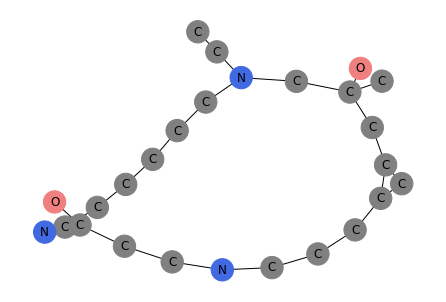

1


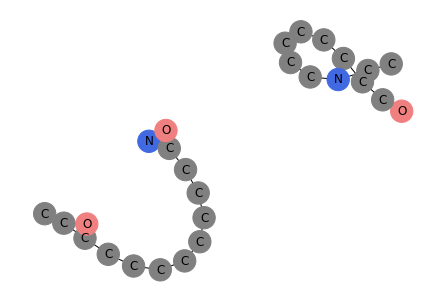

2


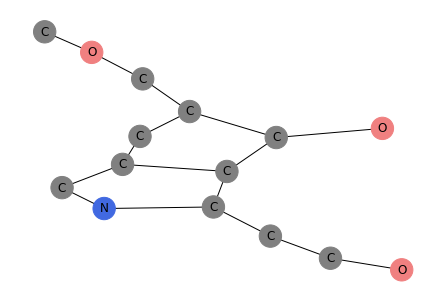

3


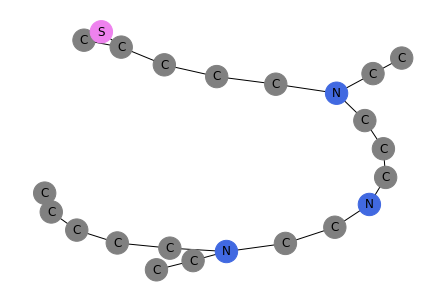

4


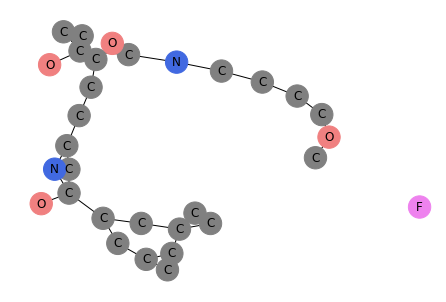

5


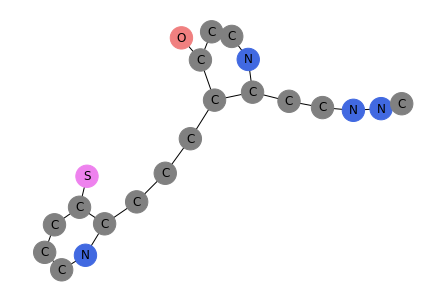

6


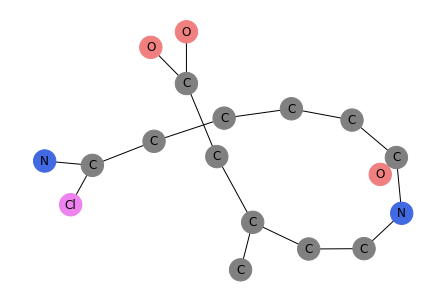

7


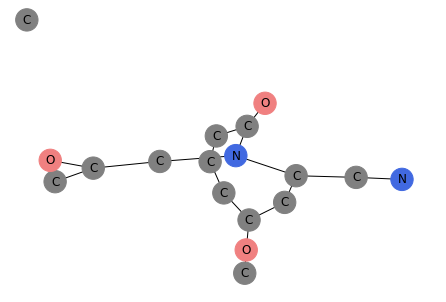

8


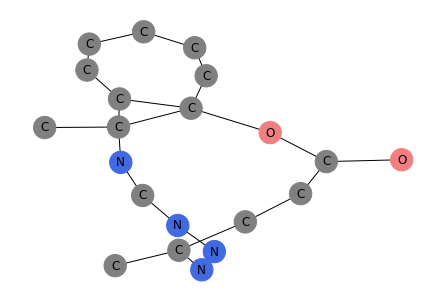

9


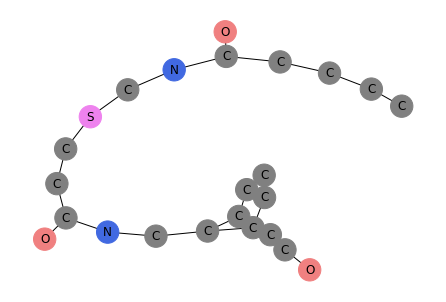

10


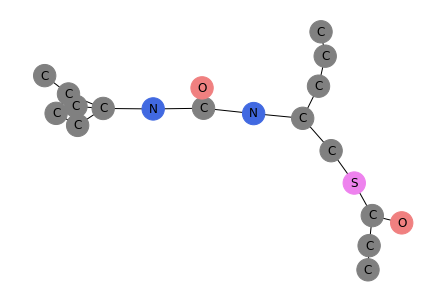

11


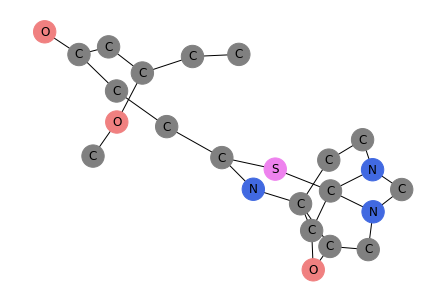

12


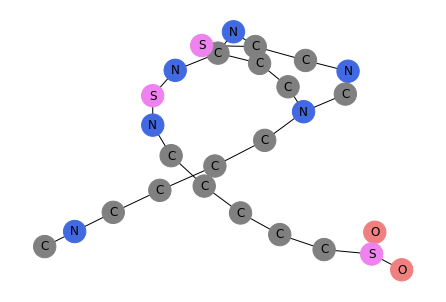

13


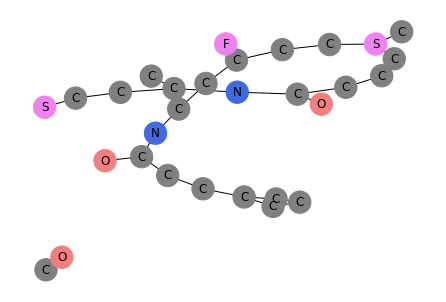

14


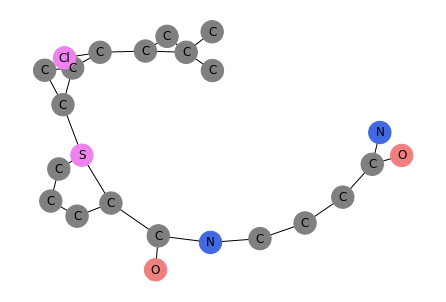

15


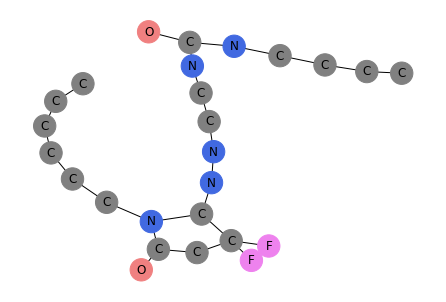

16


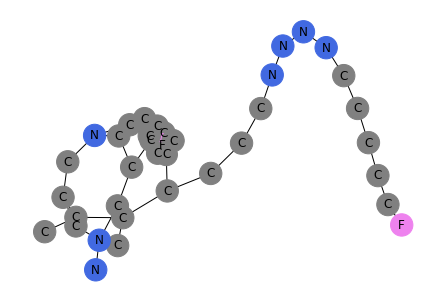

17


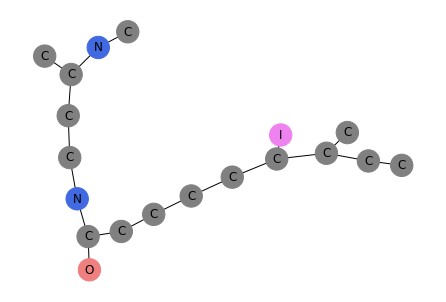

18


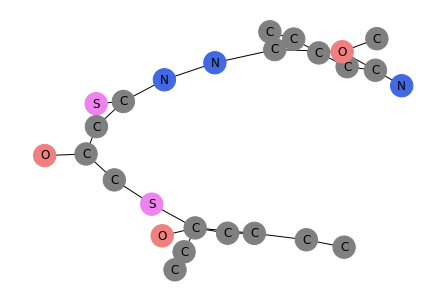

19


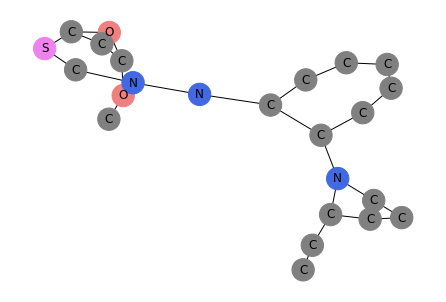

In [9]:
# Plot some randomly generated graphs
for i, g in enumerate(graphs[:20]):
    print(i)
    plot_molecule(g)